In [1]:
import Functions_Classes
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFECV,SelectKBest, SequentialFeatureSelector, f_classif, mutual_info_classif

from sklearn.impute import SimpleImputer, KNNImputer


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from feature_engine.encoding import CountFrequencyEncoder

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import iqr
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:

def preprocessing(X=None, y=None, missing_value='knn', unbalanced='smote_oversampling', scaler='robust', outliers='lof'):

    if missing_value == 'knn':
        imputer = KNNImputer(n_neighbors=10)
        X = imputer.fit_transform(X)
    elif missing_value == 'median':
        imputer = SimpleImputer(strategy='median')
        X= imputer.fit_transform(X)
    else: 
        pass


    if y is not None and unbalanced:
        if unbalanced == 'smote_oversampling':
            smote = SMOTE()
            X, y = smote.fit_resample(X, y)
        elif unbalanced == 'random_oversampling':
            ros = RandomOverSampler()
            X, y = ros.fit_resample(X, y)
        elif unbalanced == 'undersampling':
            rus = RandomUnderSampler()
            X, y = rus.fit_resample(X, y)
        else:
            pass

    if scaler == 'standard':
        scale = StandardScaler()
        X[:] = scale.fit_transform(X)
    elif scaler == 'robust':
        scale = RobustScaler()
        X[:] = scale.fit_transform(X)

    if outliers and outliers == 'lof':
        lof = LocalOutlierFactor(novelty=True)
        lof.fit(X)
        flags = lof.predict(X)
        X = X[flags > 0]
        y = y[flags > 0] if y is not None else None
    elif outliers and outliers == 'iqr':
        bounds = iqr(X, rng=(25, 75))
        lower_bound = X.quantile(0.25) - 1.5 * bounds
        upper_bound = X.quantile(0.75) + 1.5 * bounds
        X = X[(X > lower_bound) & (X < upper_bound)]
    else:
        pass
    return X, y


In [5]:
# CHI
from sklearn.preprocessing import MinMaxScaler
def selectfeatures_chi(X,y,FeatureNum=0):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    selector = SelectKBest(score_func=chi2, k=FeatureNum)
    selector.fit_transform(X_scaled, y)
    selected_features = selector.get_support()
    selected_feature_names_CHI = X.columns[selected_features].tolist()
    return selected_feature_names_CHI

In [6]:
def feature_selection(features,target, n_components=0):
    features=features.replace(np.NaN,0)
    corr_matrix=features.corr().abs()
    corr_matrix=corr_matrix.replace(np.NaN,0)
    # print(np.isnan(corr_matrix).sum().sum())
    eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)


    # Sort the eigenvalues in descending order
    sorted_indices = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

    # Determine the number of eigenvectors to keep
    n_components = np.sum(cumulative_variance < 0.95) + 1

    # Print the number of eigenvectors to keep
    print("Number of eigenvectors to keep: ", n_components)
    # # print("kept features:", sorted_eigenvectors[:n_components])
    # print("kept features:",  features.columns[sorted_indices[:n_components]])

    result=selectfeatures_chi(X=features,y=target,FeatureNum=n_components)
    return result 


In [7]:
def custom_error_cost_score(y_true, y_pred):
        error_cost_matrix = np.array([[0, 1, 2],
                                      [1, 0, 1],
                                      [2, 1, 0]])
        cm = confusion_matrix(y_true, y_pred)
        error_value = np.sum(cm * error_cost_matrix) / len(y_true)
        
        return error_value

In [8]:
test_data = pd.read_csv(r"E:\fucking FSS 2024\DM 2\DM2_DataCraft\data\test_data_no_target.csv") # test_data path
test_data = test_data.fillna(0.001)

In [9]:
# hp tuning on rf

def Tuning(X_train, y_train):
    custom_scorer = make_scorer(custom_error_cost_score, greater_is_better=False)

    param_grid = {
        'n_estimators': [250,300,350],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'random_state': [0],
    }

    rf = RandomForestClassifier()

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=custom_scorer, cv=3)

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    return grid_search.best_estimator_


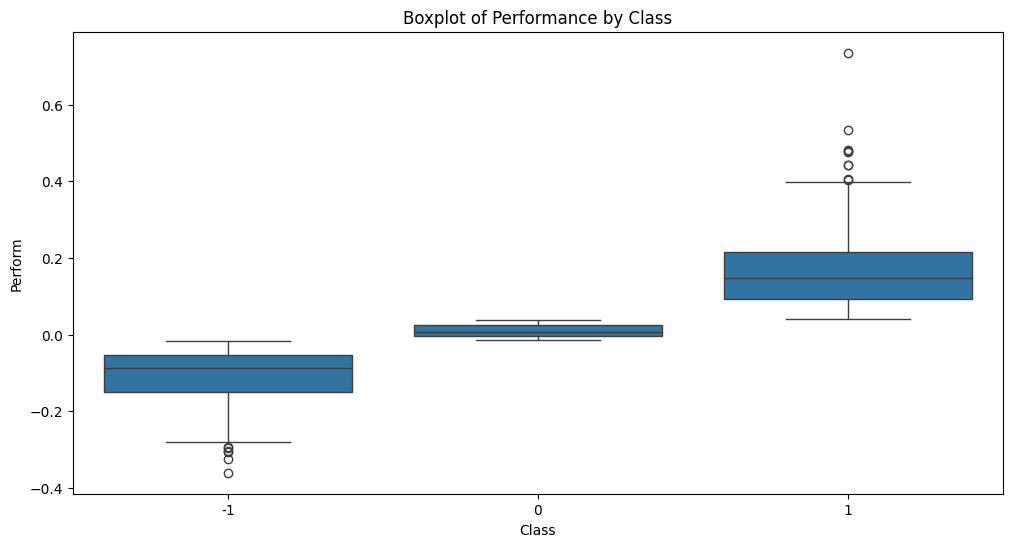

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


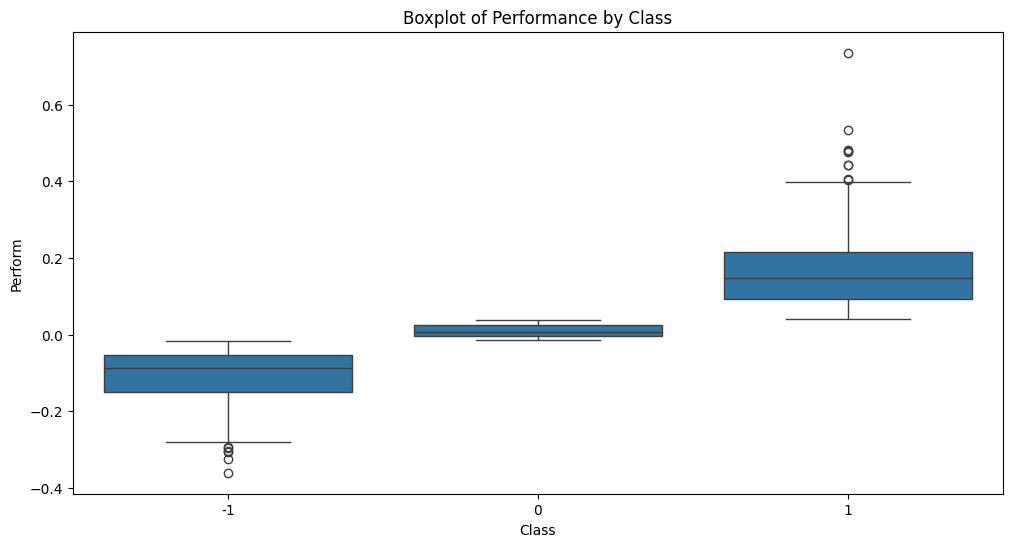

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


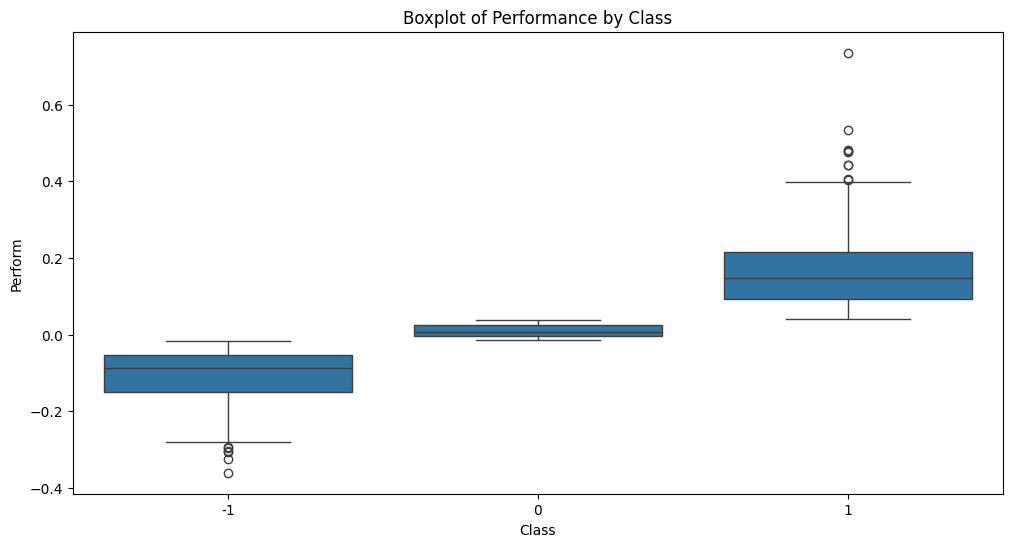

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


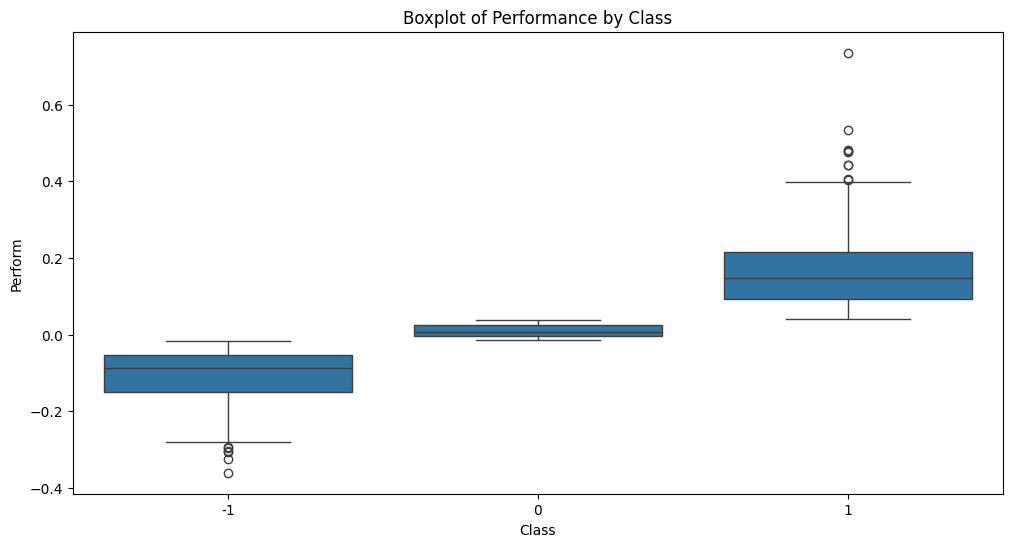

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


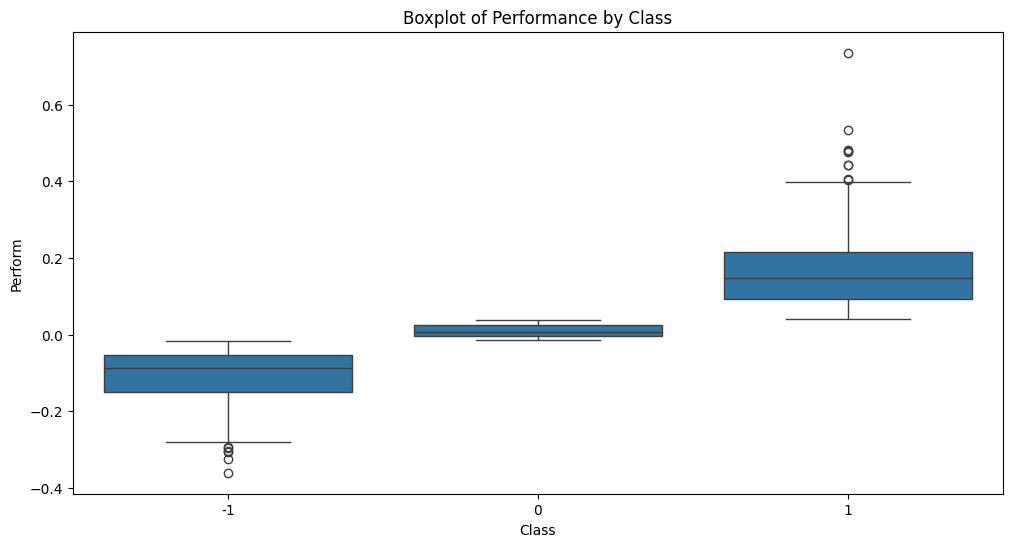

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


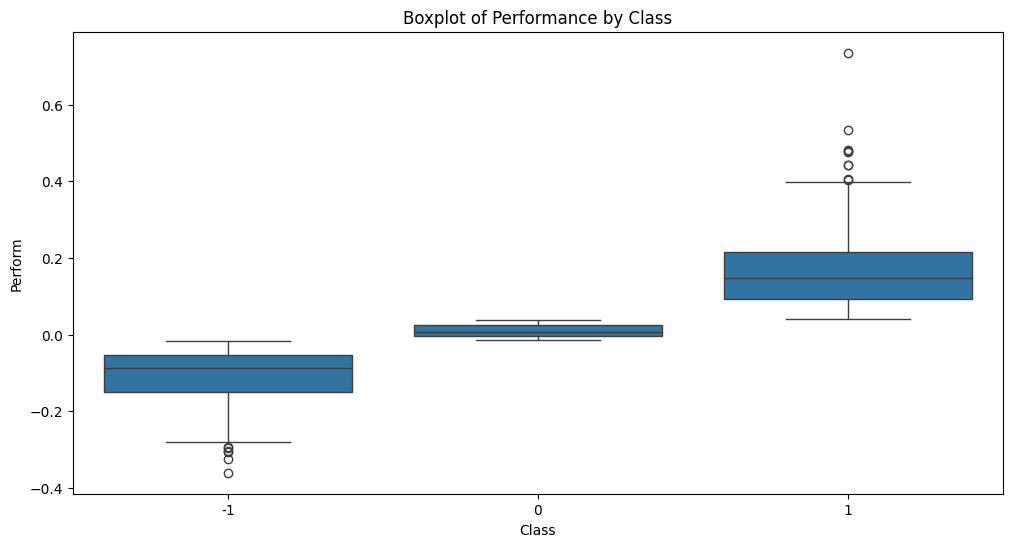

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


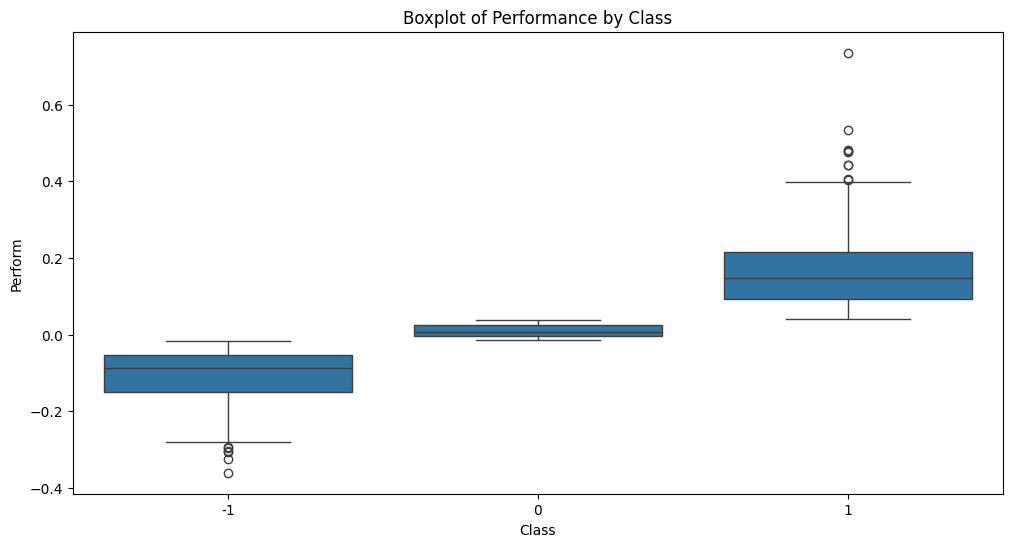

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


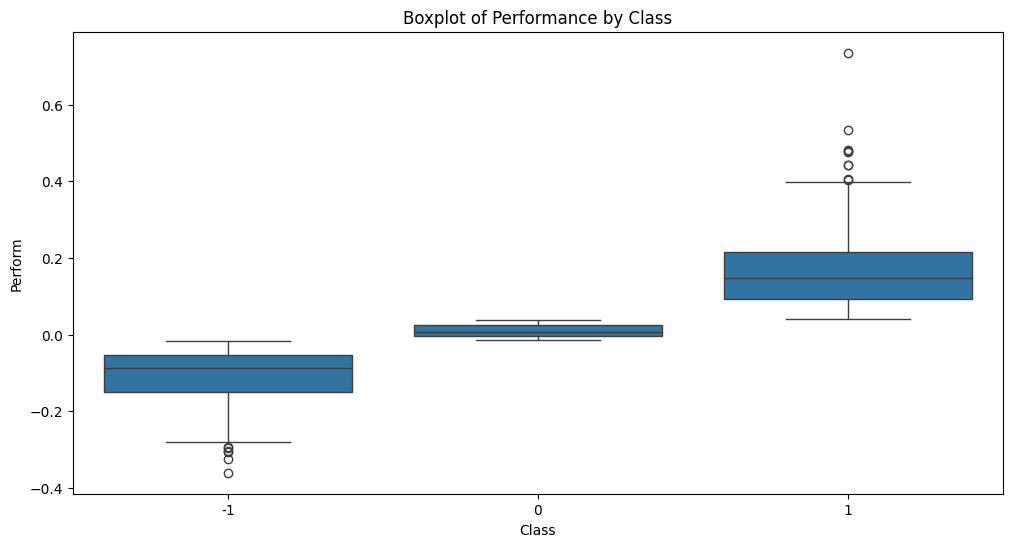

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


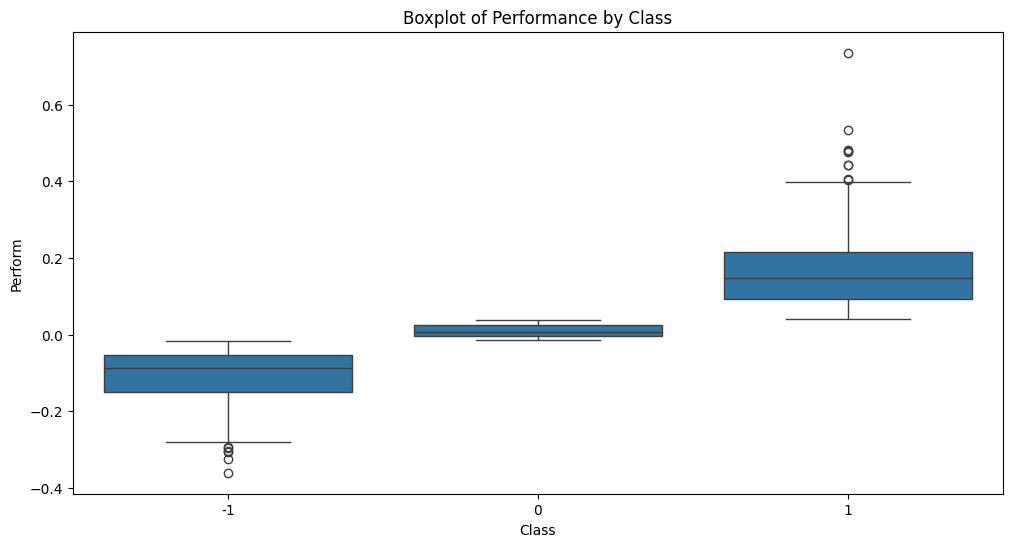

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


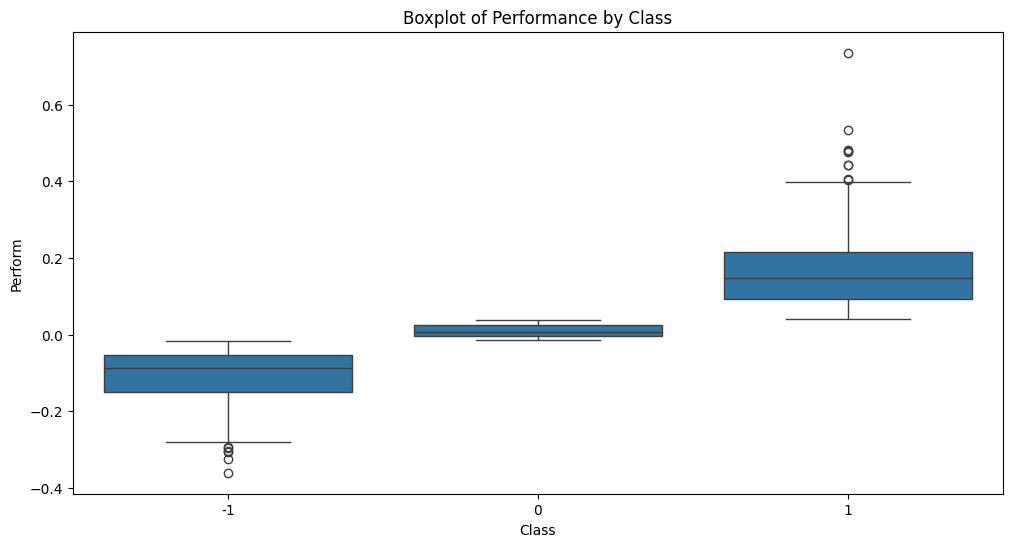

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


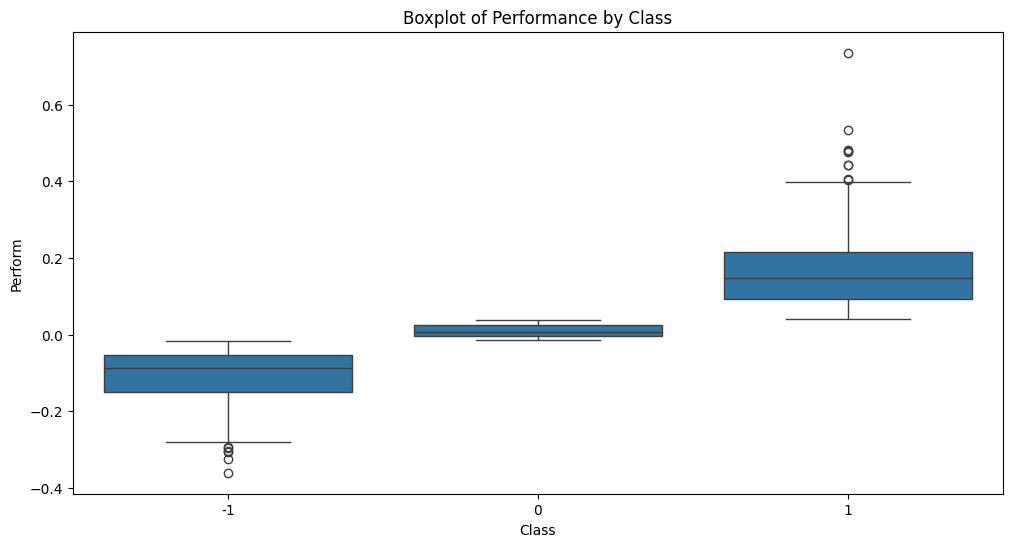

       count      mean       std       min       25%       50%       75%  \
Class                                                                      
-1     349.0 -0.108058  0.070979 -0.360030 -0.148462 -0.087671 -0.052746   
 0     118.0  0.010392  0.016597 -0.014850 -0.003440  0.007820  0.025620   
 1     413.0  0.166494  0.099318  0.040099  0.091874  0.146967  0.216689   

            max  
Class            
-1    -0.016118  
 0     0.038717  
 1     0.735159  


In [6]:

for i in range(1,12):
    data = pd.read_csv("data/G{}.csv".format(1))   # grouped train data 

    # distribution of performance under classes
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Class', y='Perform', data=data)
    plt.title('Boxplot of Performance by Class')
    plt.show()

    grouped_stats = data.groupby('Class')['Perform'].describe()
    print(grouped_stats)


In [29]:


for i in range (1,12):
    print("G{}".format(i))
    data=pd.read_csv("data/G{}.csv".format(i))
    X = data.drop(columns=["Group","Class", "Perform"])
    thresh = int(len(data) * 0.1)
    X = X.dropna(axis=1, thresh=thresh)
    print(X.shape)
    y = data["Class"]
    y_p=data["Perform"]
    # preprocessing on separate groups
    X_preprocessed, y_preprocessed = preprocessing(X, y, missing_value='knn', unbalanced='smote_oversampling', scaler='robust', outliers='lof')
    X_preprocessed=pd.DataFrame(X_preprocessed,columns=X.columns)
    result=feature_selection(X_preprocessed,y_preprocessed)
    X_selected = X_preprocessed[result]
    # print(X_selected)
    
    ## Linear regression on performance
    best_parameters = {
                   'max_depth': 4, 
                   'max_features': 'log2', 
                   'min_samples_leaf': 6, 
                   'min_samples_split': 3, 
                   'n_estimators': 291, 
                   'random_state': 42}
    model=RandomForestClassifier(**best_parameters)
    model.fit(X_preprocessed, y_preprocessed)

    
    # hp tuning here
    # best_model=Tuning(X_train, y_train) 


    # here just control error under 0.7 by repeating random forest, droped them after finish hp tuning
    # minerror=1
    # while (minerror>=0.7):
    #     model = RandomForestClassifier()
    #     model.fit(X_train, y_train)
    #     y_pred=model.predict(X_test)
    #     error=custom_error_cost_score(y_test, y_pred)
    #     if error < minerror:
    #         minerror=error
    # print(minerror)


    # predict test
    test_p=test_data[test_data["Group"]== "G{}".format(i)]
    test_p=test_p[X_preprocessed.columns]
    # test_p=test_p[result]
    scale = RobustScaler()
    test_p[:] = scale.fit_transform(test_p)
    imputer = KNNImputer(n_neighbors=5)
    test_p[:] = imputer.fit_transform(test_p)
    
    # best_model.fit(X_selected,y_preprocessed)
    predicted=model.predict(test_p)
    test_data.loc[test_data['Group'] == "G{}".format(i), 'predictions'] = predicted
test_data.to_csv('predict.csv', index=False)
    


G1
(880, 110)
Number of eigenvectors to keep:  38
G2
(1374, 116)
Number of eigenvectors to keep:  40
G3
(383, 116)
Number of eigenvectors to keep:  32
G4
(1043, 116)
Number of eigenvectors to keep:  42
G5
(829, 116)
Number of eigenvectors to keep:  37
G6
(1019, 116)
Number of eigenvectors to keep:  36
G7
(677, 116)
Number of eigenvectors to keep:  34
G8
(585, 116)
Number of eigenvectors to keep:  30
G9
(753, 116)
Number of eigenvectors to keep:  37
G10
(160, 110)
Number of eigenvectors to keep:  25
G11
(297, 116)
Number of eigenvectors to keep:  30
